In [109]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima_process import ArmaProcess
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import sklearn.metrics as skmetrics
import warnings
warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'retina'

In [110]:
def diff(data, interval=1):
    diff = list()
    for i in range(interval, len(data)):
        value = data[i] - data[i - interval]
        diff.append(value)
    return diff

In [111]:
def rmse_arima(train, val, p_values, d_values, q_values):
    best_score, best_order, best_seasonal_order = float("inf"), None, None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                res = sm.tsa.statespace.SARIMAX(train, order=order, seasonal_order=(0, 0, 0, 0),
                                                enforce_stationarity=False,
                                                enforce_invertibility=False).fit()
                pred = res.predict(start=len(train), end=len(train)+len(val)-1)
                rmse = rmse_func(val, pred)
                print(f'ARIMA order {order}, RMSE {rmse}')
                if rmse < best_score:
                    best_score, best_order = rmse, order
    print()
    print()
    print(f'best RMSE score: {best_score},best order : {best_order}')

In [112]:
def rmse_sarima(train, val, p_values, d_values, q_values, P_values, Q_values, m, D=1,):
    best_score, best_order, best_seasonal_order = float("inf"), None, None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for Q in Q_values:
                        order = (p, d, q)
                        seasonal_order = (P, D, Q, m)
                        try:
                            res = sm.tsa.statespace.SARIMAX(train, order=order, seasonal_order=seasonal_order,
                                                            enforce_stationarity=False,
                                                            enforce_invertibility=False).fit()
                            pred = res.predict(
                                start=len(train), end=len(train)+len(val)-1)
                            rmse = rmse_func(val, pred)
                            print(
                                f'SARIMA order {order},SARIMA Seasonal order {seasonal_order}, RMSE {rmse}')
                            if rmse < best_score:
                                best_score, best_order, best_seasonal_order = rmse, order, seasonal_order
                        except:
                            continue
    print((best_score, best_order, best_seasonal_order))

In [113]:
def rmse_func(true, pred):
    rmse = np.sqrt(skmetrics.mean_squared_error(true, pred))
    return rmse

### EDA

In [114]:
series = pd.read_csv('zillow-carlifornia.csv', skiprows=0,
                     index_col=0, parse_dates=True, squeeze=True)

In [115]:
# nan is the test data
series.columns = ['median_price', 'median_rate', 'unemploy_rate']
test = series[series.median_price.isna()]
series.dropna(inplace=True)

In [116]:
# 80% train, 20% val
train = series[:int(0.8*len(series))]
val = series[int(0.8*len(series)):]

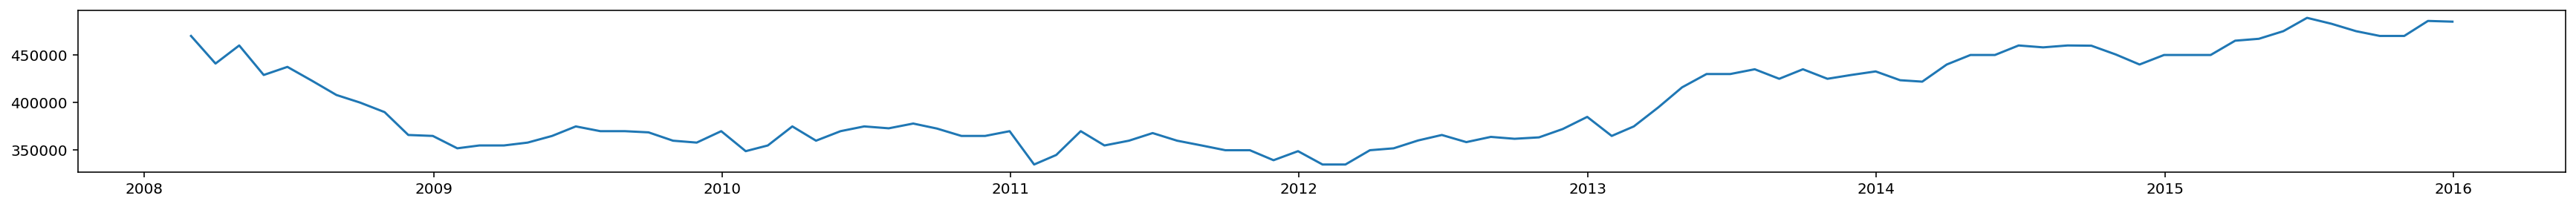

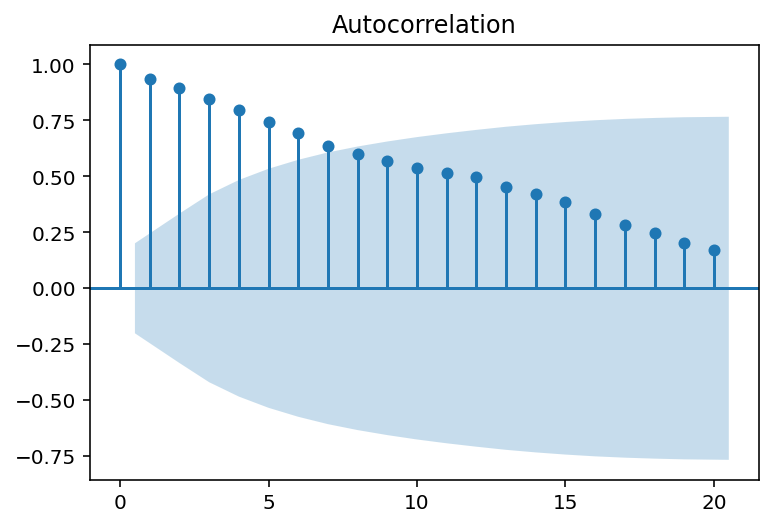

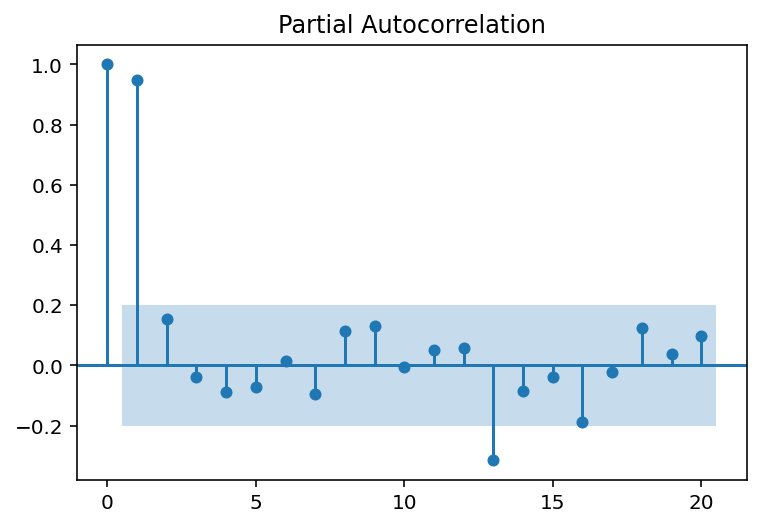

In [117]:
x = series.median_price
fig = plt.figure(figsize=(30, 2))
ax = fig.add_subplot(111)
ax.plot(x)
plt.show()
plot_acf(x, lags=20)
plt.show()
plot_pacf(x, lags=20)
plt.show()

### candidate 1:ARIMA

At first , from plot of time series, it has no significant seasonality at the first glance.

In [13]:
# PACF shut off 1, ACF decaying
dftest = adfuller(x, autolag='AIC')
dfoutput = pd.Series(dftest[0:2], index=['Test Statistic', 'p-value'])
print(dfoutput)

Test Statistic   -0.058792
p-value           0.953391
dtype: float64


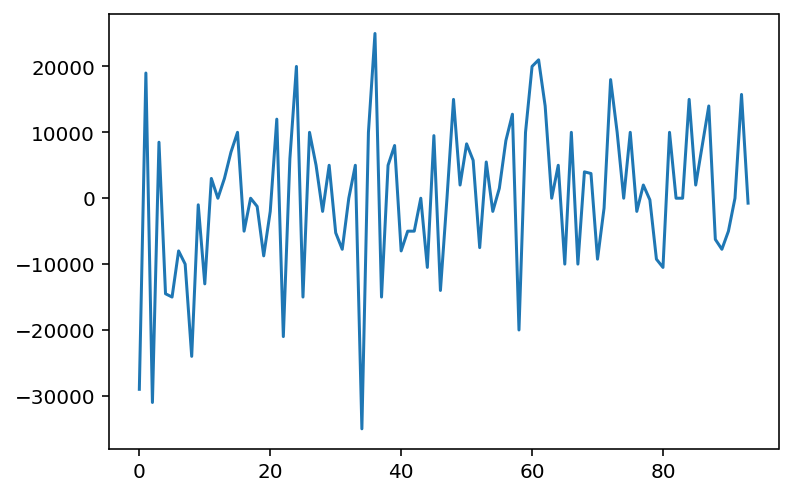

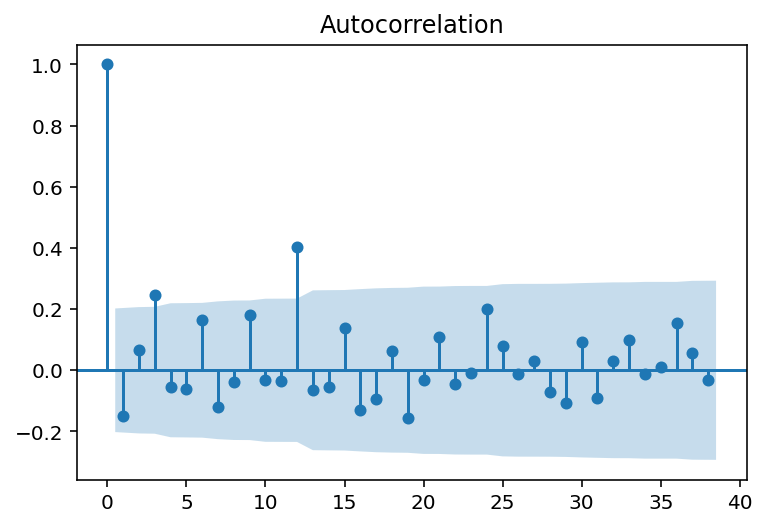

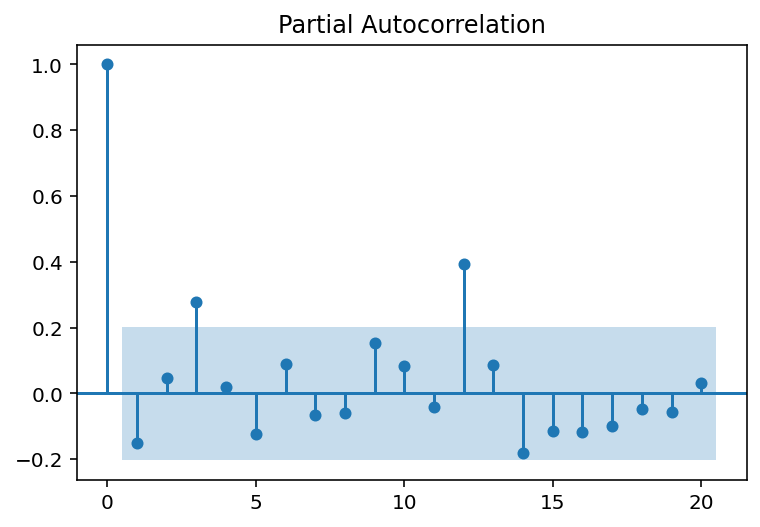

Test Statistic   -3.088139
p-value           0.027443
dtype: float64


In [14]:
d1 = diff(x, 1)
plt.plot(d1)
plot_acf(d1, lags=38)
plt.show()
plot_pacf(d1, lags=20)
plt.show()


dftest = adfuller(d1, autolag='AIC')
dfoutput = pd.Series(dftest[0:2], index=['Test Statistic', 'p-value'])
print(dfoutput)

when d=1 shows adf test shows stationary

In [11]:
p_values = range(0, 3)
d_values = [0, 1]  # set d=0 for ARMA(p,q) model
q_values = range(0, 3)

rmse_arima(train.median_price, val.median_price, p_values, d_values, q_values)

ARIMA order (0, 0, 0), RMSE 465611.93111295684
ARIMA order (0, 0, 1), RMSE 456797.8513413035
ARIMA order (0, 0, 2), RMSE 449551.2445481512
ARIMA order (0, 1, 0), RMSE 20672.81140964981
ARIMA order (0, 1, 1), RMSE 20783.958696665613
ARIMA order (0, 1, 2), RMSE 20027.27334512575
ARIMA order (1, 0, 0), RMSE 26933.52011924719
ARIMA order (1, 0, 1), RMSE 21626.421960915854
ARIMA order (1, 0, 2), RMSE 20406.15690118554
ARIMA order (1, 1, 0), RMSE 20672.81140964981
ARIMA order (1, 1, 1), RMSE 20692.62279397518
ARIMA order (1, 1, 2), RMSE 14257.156855114898
ARIMA order (2, 0, 0), RMSE 21331.75771201316
ARIMA order (2, 0, 1), RMSE 24922.860662449195
ARIMA order (2, 0, 2), RMSE 17360.19288092604
ARIMA order (2, 1, 0), RMSE 20276.07043030494
ARIMA order (2, 1, 1), RMSE 20305.727078602547
ARIMA order (2, 1, 2), RMSE 20400.776226724654


best RMSE score: 14257.156855114898,best order : (1, 1, 2)


<li >candidate 1 will be ARIMA(1,1,2) with RMSE score: 14257

### candidate 2: ETS 

<li>When use ETS model as quick replacement for SARIMA model. With the seasonal decomposition plot, we find that it actually has the 12 months seasonality. 
<li> From the Residual plot, it shows multiplicative mode

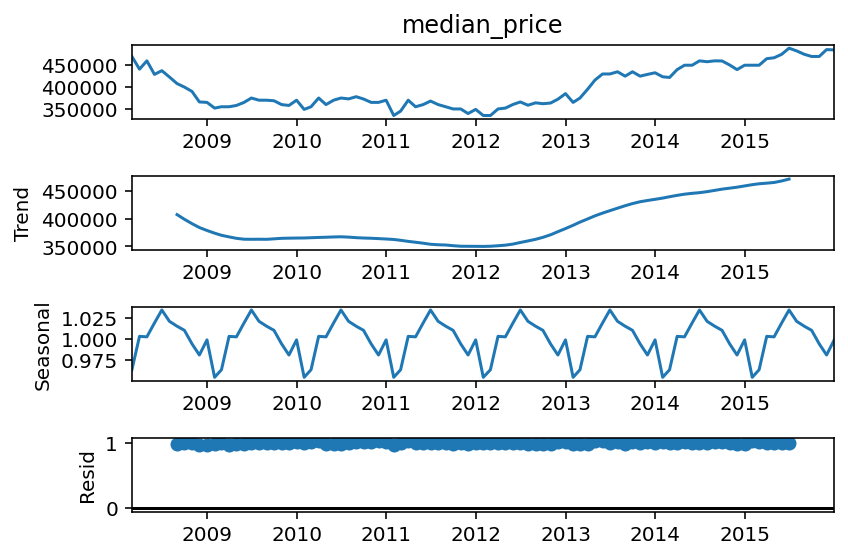

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(series.median_price, model='multiplicative')
result.plot()
plt.show()

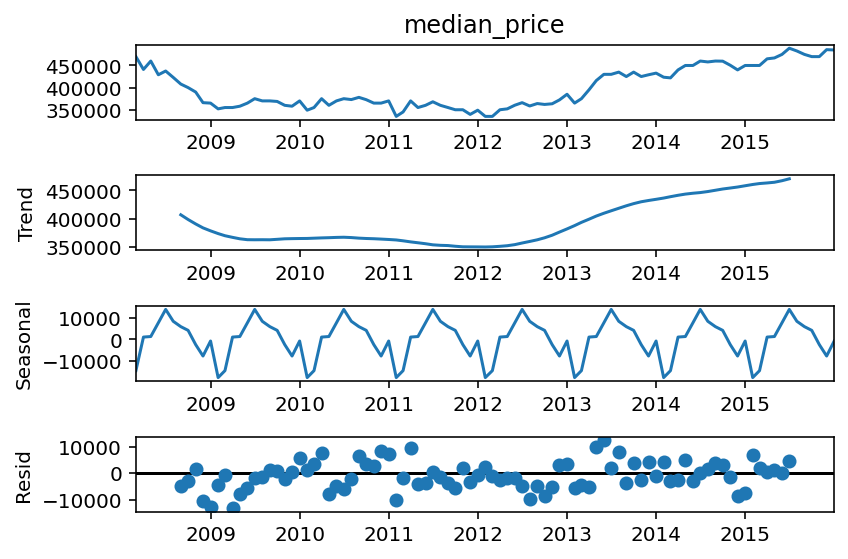

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(series.median_price, model='addictive')
result.plot()
plt.show()

In [148]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [147]:
def ETS(train, val, m=12):
    for trend in ['add', 'mul', None]:
        for seasonal in ['add', 'mul']:
            if trend == None:
                damped = False
            else:
                damped = True
            model = ExponentialSmoothing(
                train, trend=trend, seasonal=seasonal, seasonal_periods=m, damped=damped)
            fit = model.fit()
            pred = fit.forecast(len(val))
            rmse = rmse_func(val, pred)
            print(f"trend: {trend},  seanonal: {seasonal},  rmse: {rmse}")

In [14]:
ETS(train.median_price, val.median_price)

trend: add,  seanonal: add,  rmse: 11528.00571808436
trend: add,  seanonal: mul,  rmse: 12642.497121296423
trend: mul,  seanonal: add,  rmse: 11795.340106761016
trend: mul,  seanonal: mul,  rmse: 10176.708252400247
trend: None,  seanonal: add,  rmse: 20172.805384600037
trend: None,  seanonal: mul,  rmse: 19911.781939191795


candidate2 ETS(mul,mul)

### candidate 3: SARIMA

<li>We still not satisfied with the ARIMA and ETS results, so we try grid search SARIMA model with Differnce once since it show stationary on the ACF plot.

In [15]:
# when d=1 shows adf test shows stationary
p_values = range(0, 4)
d_values = [0, 1]  # set d=0 for ARMA(p,q) model
q_values = range(0, 4)
P_values = range(0, 4)
Q_values = range(0, 4)
rmse_sarima(train.median_price, val.median_price, p_values,
            d_values, q_values, P_values, Q_values, 12)

SARIMA order (0, 0, 0),SARIMA Seasonal order (0, 1, 0, 12), RMSE 36144.67457316499
SARIMA order (0, 0, 0),SARIMA Seasonal order (0, 1, 1, 12), RMSE 33167.120349411765
SARIMA order (0, 0, 0),SARIMA Seasonal order (0, 1, 2, 12), RMSE 15937.548951031207
SARIMA order (0, 0, 0),SARIMA Seasonal order (0, 1, 3, 12), RMSE 38347.87009685023
SARIMA order (0, 0, 0),SARIMA Seasonal order (1, 1, 0, 12), RMSE 29563.76025112921
SARIMA order (0, 0, 0),SARIMA Seasonal order (1, 1, 1, 12), RMSE 17296.96931053838
SARIMA order (0, 0, 0),SARIMA Seasonal order (1, 1, 2, 12), RMSE 17881.79435233727
SARIMA order (0, 0, 0),SARIMA Seasonal order (1, 1, 3, 12), RMSE 13776.556253108536
SARIMA order (0, 0, 0),SARIMA Seasonal order (2, 1, 0, 12), RMSE 11088.973482173697
SARIMA order (0, 0, 0),SARIMA Seasonal order (2, 1, 1, 12), RMSE 68879280.00811447
SARIMA order (0, 0, 0),SARIMA Seasonal order (2, 1, 2, 12), RMSE 49937.619136071844
SARIMA order (0, 0, 0),SARIMA Seasonal order (2, 1, 3, 12), RMSE 45549.89411895625

SARIMA order (0, 1, 2),SARIMA Seasonal order (0, 1, 3, 12), RMSE 11572.875345680652
SARIMA order (0, 1, 2),SARIMA Seasonal order (1, 1, 0, 12), RMSE 7848.427164019574
SARIMA order (0, 1, 2),SARIMA Seasonal order (1, 1, 1, 12), RMSE 8787.608303828118
SARIMA order (0, 1, 2),SARIMA Seasonal order (1, 1, 2, 12), RMSE 12604.08053040926
SARIMA order (0, 1, 2),SARIMA Seasonal order (1, 1, 3, 12), RMSE 11924.0840851134
SARIMA order (0, 1, 2),SARIMA Seasonal order (2, 1, 0, 12), RMSE 7715.679264099144
SARIMA order (0, 1, 2),SARIMA Seasonal order (2, 1, 1, 12), RMSE 7981.12517507504
SARIMA order (0, 1, 2),SARIMA Seasonal order (2, 1, 2, 12), RMSE 7154.678499620967
SARIMA order (0, 1, 2),SARIMA Seasonal order (2, 1, 3, 12), RMSE 12207.669206853381
SARIMA order (0, 1, 2),SARIMA Seasonal order (3, 1, 0, 12), RMSE 11049.871874853618
SARIMA order (0, 1, 2),SARIMA Seasonal order (3, 1, 1, 12), RMSE 11899.051905092665
SARIMA order (0, 1, 2),SARIMA Seasonal order (3, 1, 2, 12), RMSE 12623.458061751006
S

SARIMA order (1, 1, 0),SARIMA Seasonal order (1, 1, 2, 12), RMSE 12826.637131497984
SARIMA order (1, 1, 0),SARIMA Seasonal order (1, 1, 3, 12), RMSE 5744.6319620844715
SARIMA order (1, 1, 0),SARIMA Seasonal order (2, 1, 0, 12), RMSE 7458.256063229271
SARIMA order (1, 1, 0),SARIMA Seasonal order (2, 1, 1, 12), RMSE 14420.019898358762
SARIMA order (1, 1, 0),SARIMA Seasonal order (2, 1, 2, 12), RMSE 8515.58414661128
SARIMA order (1, 1, 0),SARIMA Seasonal order (2, 1, 3, 12), RMSE 7827.649913750869
SARIMA order (1, 1, 0),SARIMA Seasonal order (3, 1, 0, 12), RMSE 7965.214050841632
SARIMA order (1, 1, 0),SARIMA Seasonal order (3, 1, 1, 12), RMSE 7888.112963069713
SARIMA order (1, 1, 0),SARIMA Seasonal order (3, 1, 2, 12), RMSE 7660.511443152286
SARIMA order (1, 1, 0),SARIMA Seasonal order (3, 1, 3, 12), RMSE 7044.445197431484
SARIMA order (1, 1, 1),SARIMA Seasonal order (0, 1, 0, 12), RMSE 12250.42674943896
SARIMA order (1, 1, 1),SARIMA Seasonal order (0, 1, 1, 12), RMSE 8343.419289448808
SA

SARIMA order (2, 0, 2),SARIMA Seasonal order (2, 1, 1, 12), RMSE 51174.40953164545
SARIMA order (2, 0, 2),SARIMA Seasonal order (2, 1, 2, 12), RMSE 155564.99899618805
SARIMA order (2, 0, 2),SARIMA Seasonal order (2, 1, 3, 12), RMSE 141265.13040381452
SARIMA order (2, 0, 2),SARIMA Seasonal order (3, 1, 0, 12), RMSE 21707.498158042865
SARIMA order (2, 0, 2),SARIMA Seasonal order (3, 1, 1, 12), RMSE 84270.9911200096
SARIMA order (2, 0, 2),SARIMA Seasonal order (3, 1, 2, 12), RMSE 168905.3351332529
SARIMA order (2, 0, 2),SARIMA Seasonal order (3, 1, 3, 12), RMSE 55086.22193052668
SARIMA order (2, 0, 3),SARIMA Seasonal order (0, 1, 0, 12), RMSE 21902.305971262675
SARIMA order (2, 0, 3),SARIMA Seasonal order (0, 1, 1, 12), RMSE 414003645345939.9
SARIMA order (2, 0, 3),SARIMA Seasonal order (0, 1, 2, 12), RMSE 138193.65354206954
SARIMA order (2, 0, 3),SARIMA Seasonal order (0, 1, 3, 12), RMSE 65184.44717470902
SARIMA order (2, 0, 3),SARIMA Seasonal order (1, 1, 0, 12), RMSE 34909.26642073496


SARIMA order (3, 0, 0),SARIMA Seasonal order (3, 1, 0, 12), RMSE 14474.352829332856
SARIMA order (3, 0, 0),SARIMA Seasonal order (3, 1, 1, 12), RMSE 52734.941659751436
SARIMA order (3, 0, 0),SARIMA Seasonal order (3, 1, 2, 12), RMSE 21711.20873704812
SARIMA order (3, 0, 0),SARIMA Seasonal order (3, 1, 3, 12), RMSE 36690.338455591234
SARIMA order (3, 0, 1),SARIMA Seasonal order (0, 1, 0, 12), RMSE 23291.315419512495
SARIMA order (3, 0, 1),SARIMA Seasonal order (0, 1, 1, 12), RMSE 1.234045573521228e+33
SARIMA order (3, 0, 1),SARIMA Seasonal order (0, 1, 2, 12), RMSE 95732.61639000091
SARIMA order (3, 0, 1),SARIMA Seasonal order (0, 1, 3, 12), RMSE 9229.387842768565
SARIMA order (3, 0, 1),SARIMA Seasonal order (1, 1, 0, 12), RMSE 6935.392302911529
SARIMA order (3, 0, 1),SARIMA Seasonal order (1, 1, 1, 12), RMSE 19038.510815840746
SARIMA order (3, 0, 1),SARIMA Seasonal order (1, 1, 2, 12), RMSE 80446.74215775939
SARIMA order (3, 0, 1),SARIMA Seasonal order (1, 1, 3, 12), RMSE 164008.676041

SARIMA order (3, 1, 2),SARIMA Seasonal order (3, 1, 3, 12), RMSE 22848.326576741158
SARIMA order (3, 1, 3),SARIMA Seasonal order (0, 1, 0, 12), RMSE 36433.89758298663
SARIMA order (3, 1, 3),SARIMA Seasonal order (0, 1, 1, 12), RMSE 23543.540758836167
SARIMA order (3, 1, 3),SARIMA Seasonal order (0, 1, 2, 12), RMSE 7623.508938543206
SARIMA order (3, 1, 3),SARIMA Seasonal order (0, 1, 3, 12), RMSE 28262.962321504052
SARIMA order (3, 1, 3),SARIMA Seasonal order (1, 1, 0, 12), RMSE 9518.937076509386
SARIMA order (3, 1, 3),SARIMA Seasonal order (1, 1, 1, 12), RMSE 9362.029431479448
SARIMA order (3, 1, 3),SARIMA Seasonal order (1, 1, 2, 12), RMSE 11946.169074289908
SARIMA order (3, 1, 3),SARIMA Seasonal order (1, 1, 3, 12), RMSE 10196.74241136841
SARIMA order (3, 1, 3),SARIMA Seasonal order (2, 1, 0, 12), RMSE 10970.675819263084
SARIMA order (3, 1, 3),SARIMA Seasonal order (2, 1, 1, 12), RMSE 10797.770106025668
SARIMA order (3, 1, 3),SARIMA Seasonal order (2, 1, 2, 12), RMSE 8620.28220135969

Our Best model in here: SARIMA((1, 1, 0), (1, 1, 3, 12)) with RMSE = 5744.6319620844715

### candidate 4: Multivariate

Add more features is also worth trying. So we decide to try Multivariate model again to see we can get better results by adding more predicting features.


In [118]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))

train_sc = sc.fit_transform(train)
val_sc = sc.transform(val)

In [141]:
# auto sarimax search with seasonality
# We tried D=1 and D=2. D=2 performance better so we select our candidate in here
from pmdarima.arima import auto_arima
model4 = auto_arima(train_sc[:, 0],
                    exogenous=train_sc[:, 1:],  # rest as exogenous
                    start_p=0, start_q=0,
                    max_p=4, max_q=4,d=1,
                    max_d=2,
                    m=12, D=0, max_P=4, max_Q=4,
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True, information_criterion='oob', n_jobs=-1)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=-159.524, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-141.321, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-161.098, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-158.299, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-143.249, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-141.190, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-159.303, Time=0.46 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-159.314, Time=0.24 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-158.762, Time=0.12 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-157.530, Time=0.72 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-160.669, Time=0.12 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=-163.281, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=-139.634, Time=0.07 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=-161.295, Time=0.64 sec
 ARIMA(2,1,0)(1,0,1

In [145]:
y_pred = model4.predict(n_periods=len(val_sc), X=val_sc[:, 1:]).reshape(-1, 1)
# duplicate the pred column x3 times to fit the scaler's shape
y_pred_ = np.repeat(y_pred, 3, axis=1)

In [143]:
y_pred_inv = sc.inverse_transform(y_pred_)[:, 0]

In [144]:
rmse_func(val.median_price, y_pred_inv)

18221.85819166622

<li>we get our forth candidate, SARIMAX(4,1,0)(1,0,0)[12] 

### Model Assessment on validation set

In [149]:
# model1 ARIMA(1,1,2)
model1 = sm.tsa.statespace.SARIMAX(train.median_price, order=(1, 1, 2), seasonal_order=(0, 0, 0, 0),
                                   enforce_stationarity=False,
                                   enforce_invertibility=False).fit()
pred1 = model1.predict(start=len(train), end=len(train)+len(val)-1)

# model2 ETS(mul,mul)
model2 = ExponentialSmoothing(train.median_price,
                              trend='mul',
                              seasonal='mul',
                              seasonal_periods=12,
                              damped=True).fit()
pred2 = model2.forecast(len(val))
# model3 SARIMA(1, 1, 0),(1, 1, 3, 12)
model3 = sm.tsa.statespace.SARIMAX(train.median_price, order=(1, 1, 0), seasonal_order=(1, 1, 3, 12),
                                   enforce_stationarity=False,
                                   enforce_invertibility=False).fit()
pred3 = model3.predict(start=len(train), end=len(train)+len(val)-1)
# model4 SARIMAX(4,1,0)(1,0,0)[12]
y_pred = model4.predict(n_periods=len(val_sc), X=val_sc[:, 1:]).reshape(-1, 1)
# duplicate the pred column x3 times to fit the scaler's shape
y_pred_ = np.repeat(y_pred, 3, axis=1)
pred4 = sc.inverse_transform(y_pred_)[:, 0]
# index of pred2 is the last day of each month, use last day of each month as index of pred4
pred4 = pd.Series(pred4, index=pred2.index)

In [150]:
rmse1 = rmse_func(val.median_price, pred1)
rmse2 = rmse_func(val.median_price, pred2)
rmse3 = rmse_func(val.median_price, pred3)
rmse4 = rmse_func(val.median_price, pred4)

In [151]:
data = {'RMSE': [rmse1, rmse2, rmse3, rmse4]}
val_RMSE = pd.DataFrame(data, index=['ARIMA', 'ETS', 'SARIMA', 'SARIMAX'])
val_RMSE

,RMSE
ARIMA,14257.156855
ETS,10176.708252
SARIMA,5744.631962
SARIMAX,18221.858192


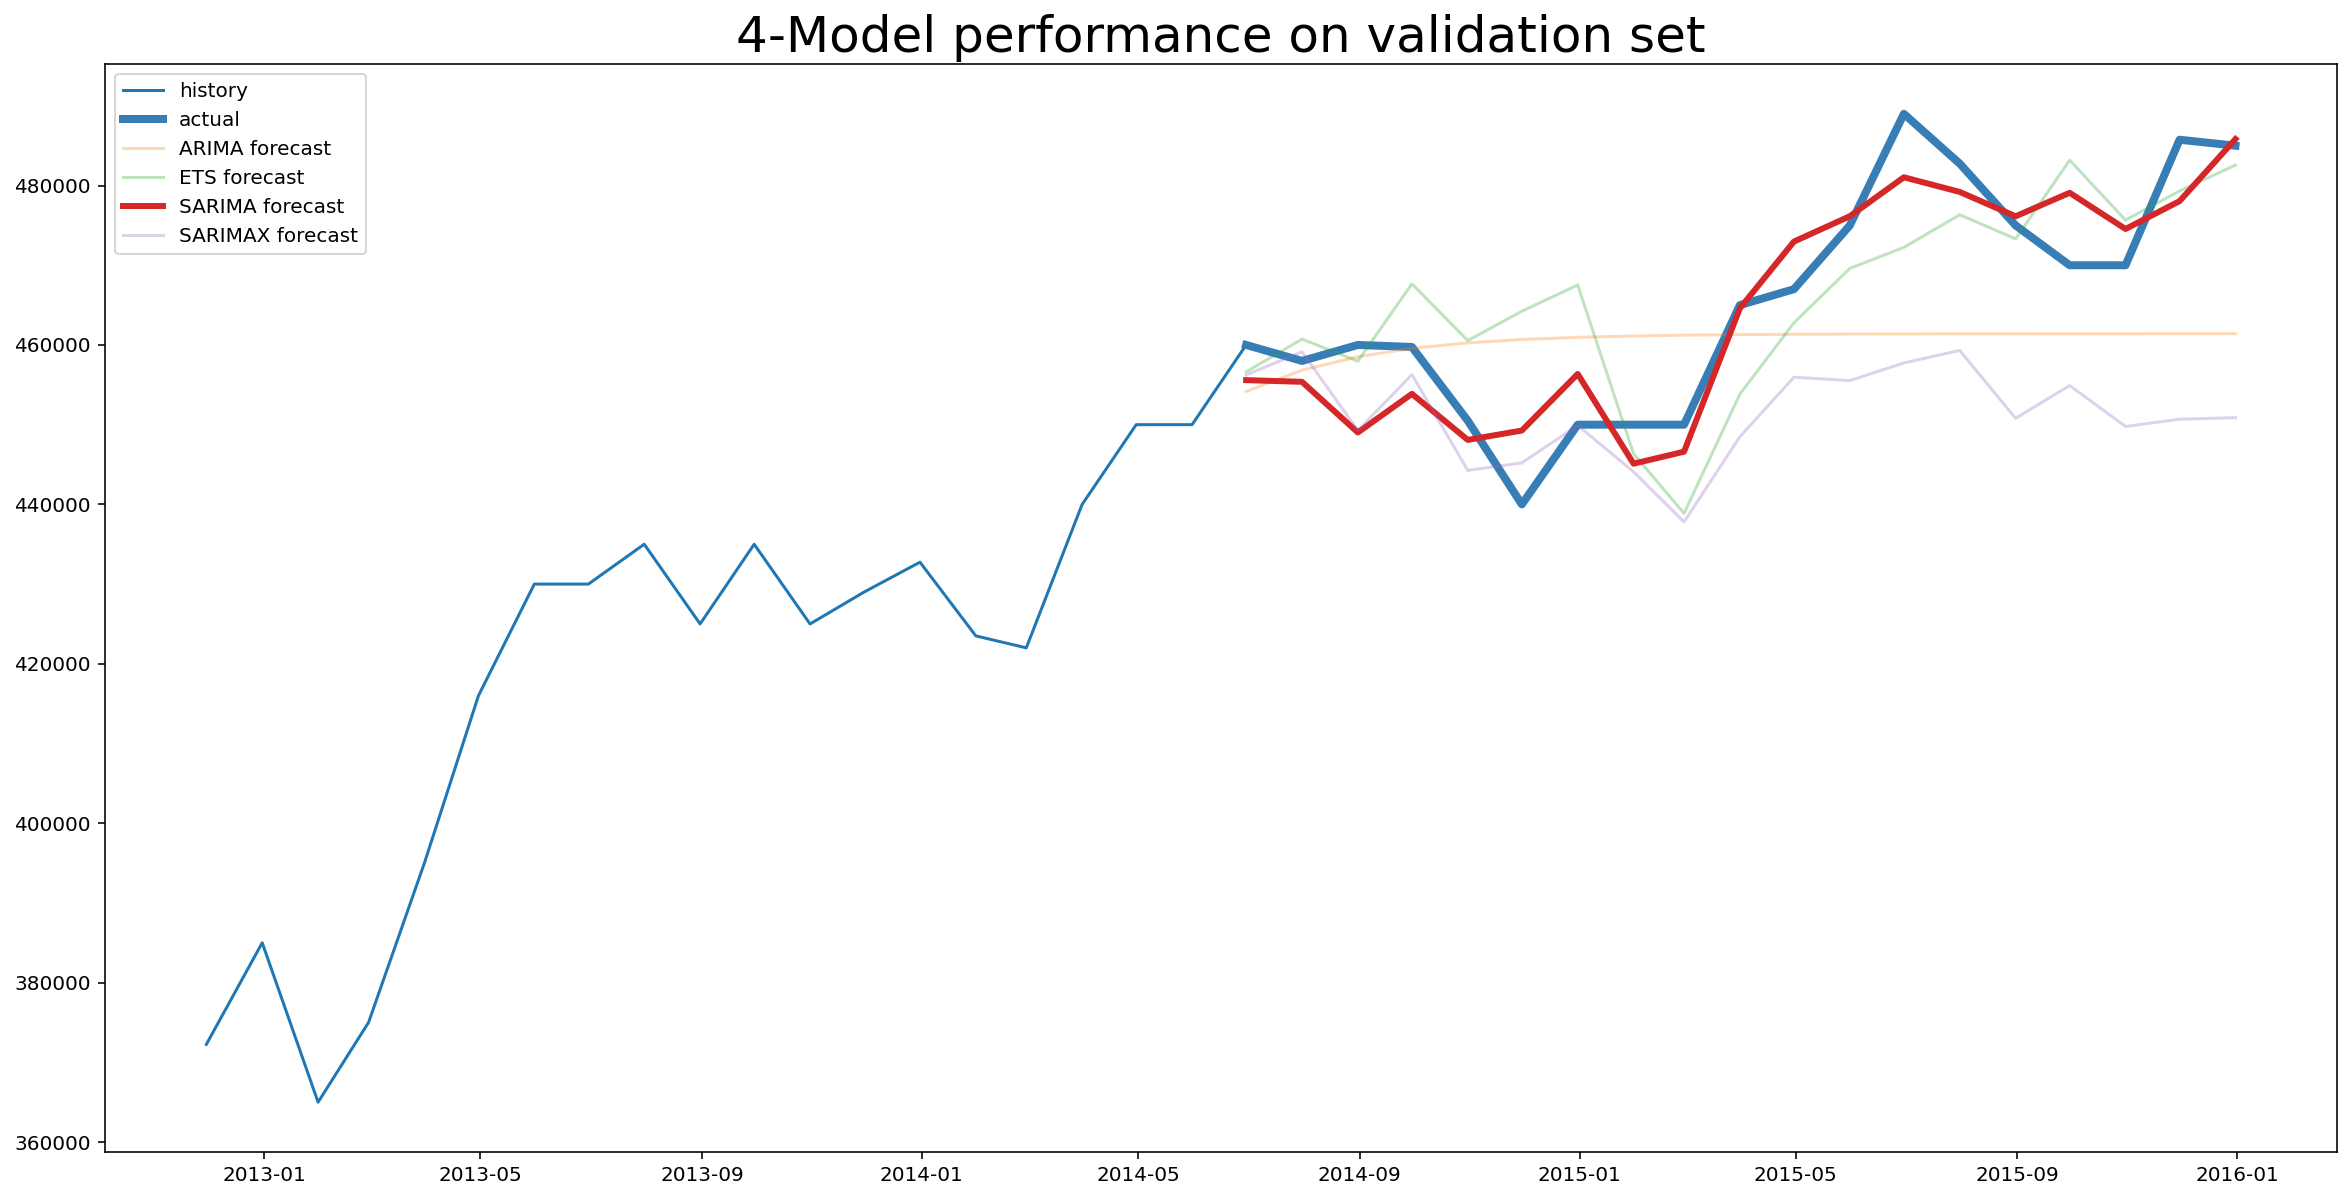

In [152]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(series.median_price[int(0.6*len(series)):], label='history')
ax.plot(val.median_price, label='actual', linewidth=4, color='#377eb7')
ax.plot(pred1, label='ARIMA forecast', alpha=0.3)
ax.plot(pred2, label='ETS forecast', alpha=0.3)
ax.plot(pred3, label='SARIMA forecast', alpha=1, linewidth=3)
ax.plot(pred4, label='SARIMAX forecast', alpha=0.3)
ax.set_title('4-Model performance on validation set',
             fontsize=25, loc='center')

plt.legend(loc='upper left', fontsize=10)
plt.show()

<li> SARIMA performs extremely well on this validation data set
<li>ARIMA become flat in short period cannot predict long term time series very well
<li>ETS(mul,mul) predict median house price in the second, but it needs less time for us to train the model

### Performance on the test set using SARIMA

In [47]:
model_final = sm.tsa.statespace.SARIMAX(series.median_price, order=(1, 1, 0), seasonal_order=(1, 1, 3, 12),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False).fit()

In [98]:
true_test = pd.read_csv('test.csv', index_col=0, parse_dates=True)

In [99]:
true_test = true_test.rename(columns={'Median House Price': 'median_price'})

In [52]:
pred3_test = model_final.predict(
    start=len(series), end=len(series)+len(true_test)-1)

In [54]:
df_pre = pd.DataFrame(pred3_test)
df_pre.rename(columns={'predicted_mean': 'predicted_median_house_price'})

,predicted_median_house_price
2016-01-31,475547.708549
2016-02-29,475440.794222
2016-03-31,493510.561172
2016-04-30,501792.294170
2016-05-31,511429.650036
2016-06-30,519963.996028
2016-07-31,518067.569754
2016-08-31,510997.153600
2016-09-30,511971.784087
2016-10-31,507731.871486


In [108]:
rmse = rmse_func(true_test.median_price, pred3_test)
print("Final rmse on test data:", rmse)

Final rmse on test data: 9112.99018451656


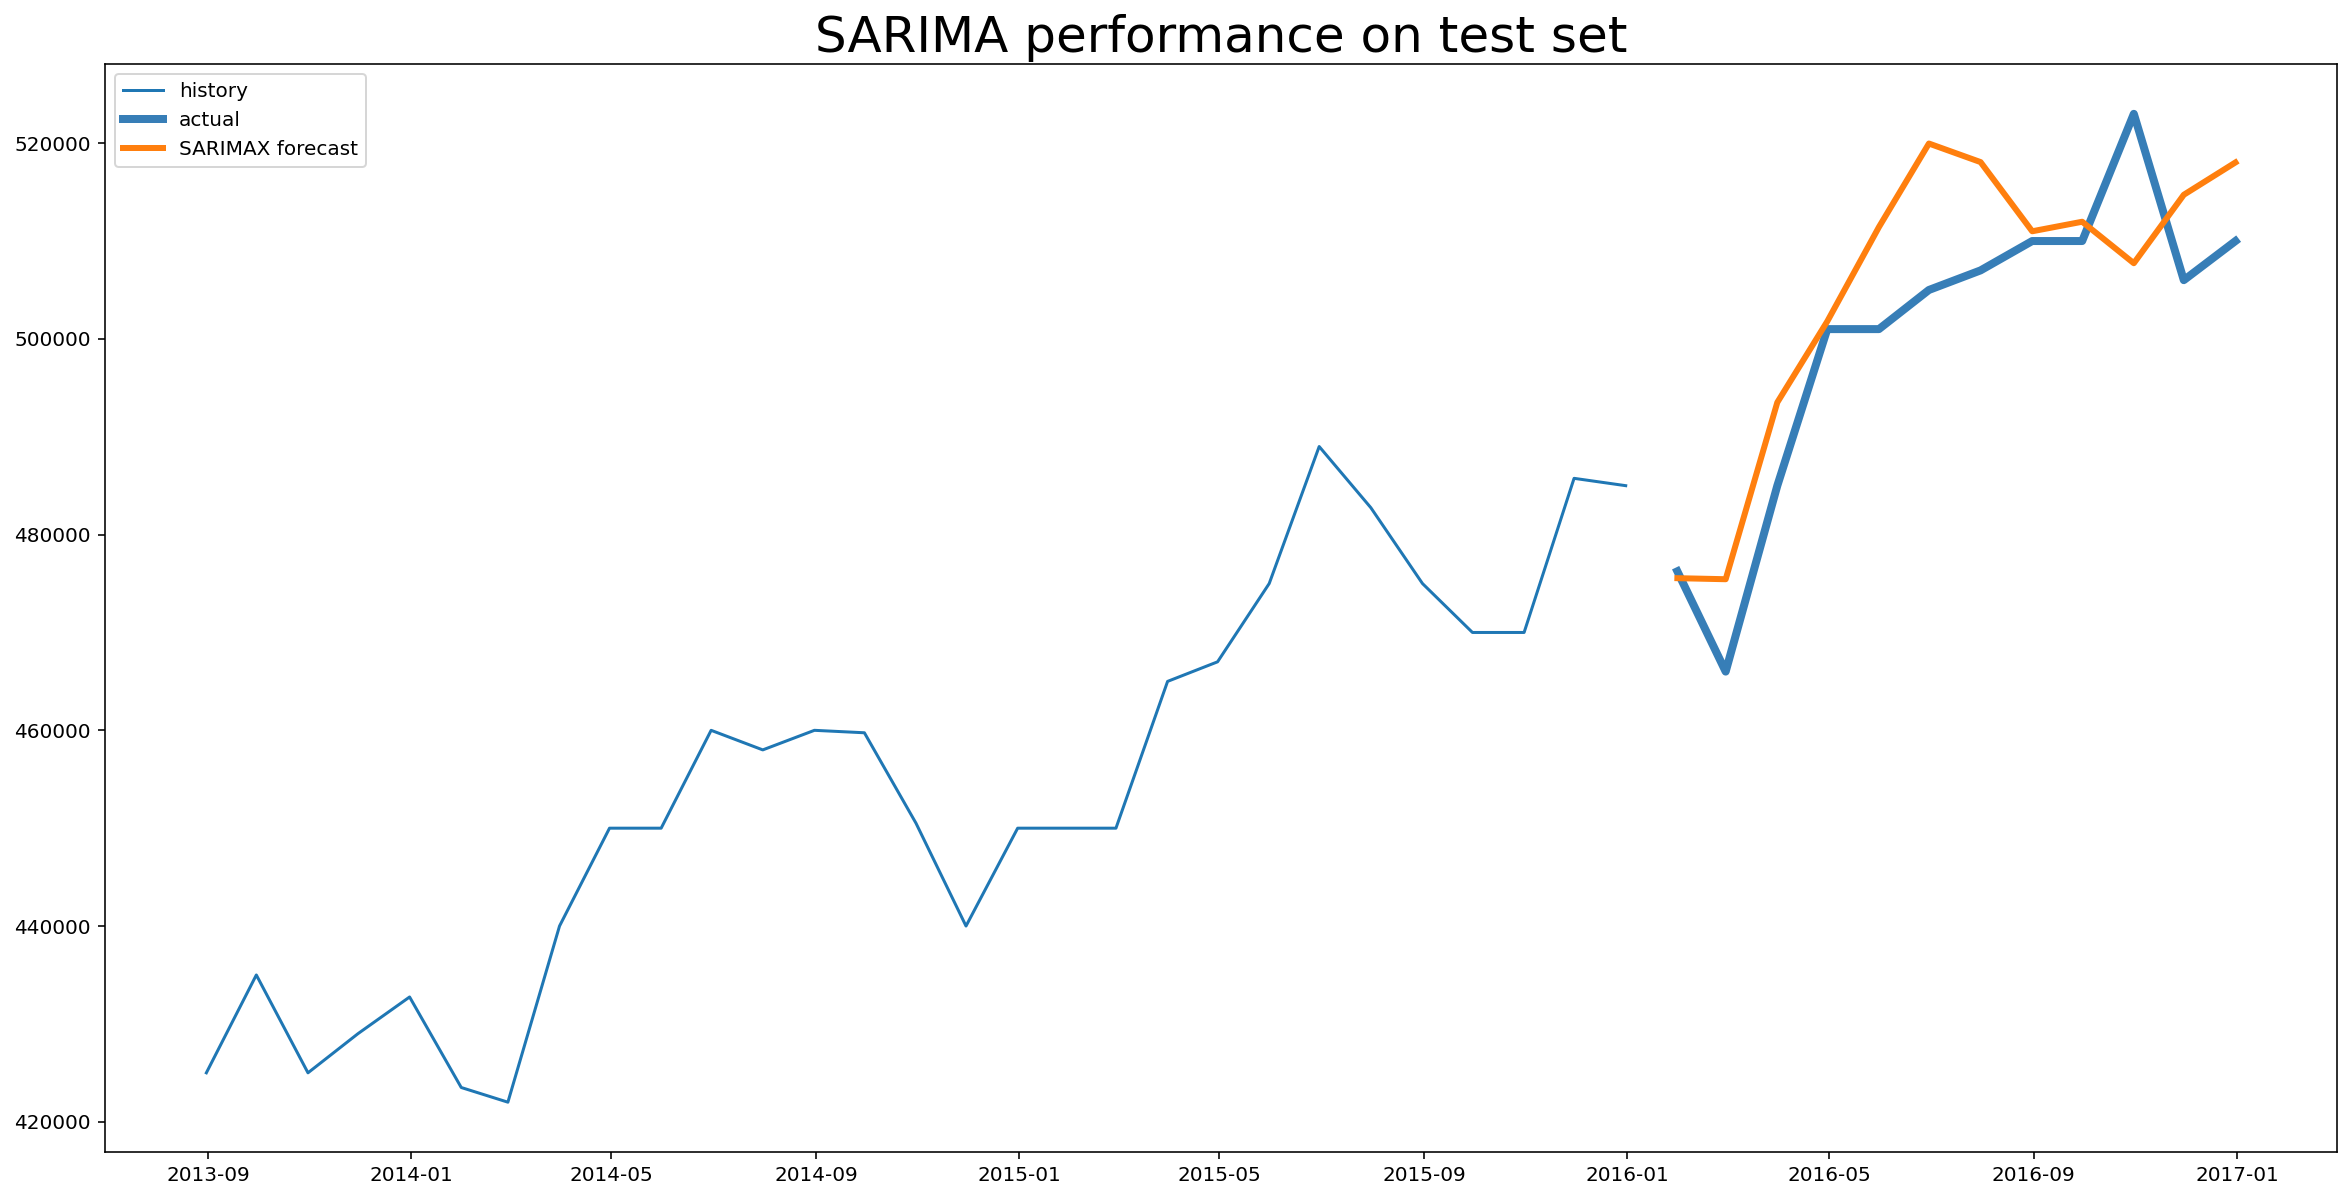

In [101]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(series.median_price[int(0.7*len(series)):], label='history')
ax.plot(true_test.median_price, label='actual', linewidth=4, color='#377eb7')
ax.plot(pred3_test, label='SARIMAX forecast', alpha=1, linewidth=3)

ax.set_title('SARIMA performance on test set', fontsize=25)
plt.legend(loc='upper left', fontsize=10)
plt.show()